<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
以下代码为 <a href="http://mng.bz/orYv">《从零开始构建大型语言模型》</a> 一书的补充代码，作者为 <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>中文翻译和代码详细注释由Lux整理，Github下载地址：<a href="https://github.com/luxianyu">https://github.com/luxianyu</a>
    
<br>Lux的Github上还有吴恩达深度学习Pytorch版学习笔记及中文详细注释的代码下载
    
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第7章：微调以遵循指令


In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.1.3
matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.9.0+cpu
tqdm version: 4.67.1
tensorflow version: 2.20.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/01.webp" width=500px>

## 7.1 指令微调简介


- 在第 5 章中，我们看到预训练 LLM 的过程涉及一种训练方法，使其学会一次生成一个单词。  
- 因此，预训练后的 LLM 擅长文本补全，但不擅长遵循指令。  
- 在本章中，我们将教 LLM 更好地遵循指令。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/02.webp" width=500px>

- 本章涵盖的主题在下图中进行了总结。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/03.webp" width=500px>


## 7.2 为有监督指令微调准备数据集


- 我们将使用我为本章准备的指令数据集。


In [2]:
# ==============================
# 导入必要的 Python 库
# ==============================
import json      # 用于读取和解析 JSON 文件
import os        # 用于操作文件路径、检查文件是否存在
import requests  # 用于发送 HTTP 请求下载文件

# ==============================
# 定义下载并加载 JSON 文件的函数
# ==============================
def download_and_load_file(file_path, url):
    """
    如果文件不存在，则从指定 URL 下载文件，并保存到本地。
    然后加载该 JSON 文件并返回解析后的 Python 对象（如 list 或 dict）。

    参数：
    - file_path: str，本地保存文件的路径
    - url: str，文件下载 URL

    返回：
    - data: Python 对象（list/dict），JSON 文件解析后的内容
    """

    # --------------------------
    # 1️⃣ 检查文件是否已经存在
    # 如果存在，则跳过下载，直接读取
    # --------------------------
    if not os.path.exists(file_path):
        # 发送 HTTP GET 请求下载文件，timeout=30 表示 30 秒超时
        response = requests.get(url, timeout=30)
        # 如果返回状态码不是 200，则抛出异常
        response.raise_for_status()

        # 将下载的文本内容存储到变量
        text_data = response.text

        # 将下载的文本写入本地文件，encoding="utf-8" 保证中文正常保存
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # --------------------------
    # 2️⃣ 文件已存在或刚下载完毕，读取 JSON 文件
    # --------------------------
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)  # json.load 解析 JSON 字符串为 Python 对象

    # 返回解析后的数据
    return data

# ==============================
# 原书中的旧版本实现
# 使用 urllib 下载文件，但协议较老，某些 VPN 环境可能无法访问
# 使用 requests 更加稳健
# ==============================
"""
import urllib

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
"""

# ==============================
# 3️⃣ 设置本地文件路径和下载 URL
# ==============================
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

# ==============================
# 4️⃣ 调用函数下载并加载 JSON 文件
# ==============================
data = download_and_load_file(file_path, url)

# 打印数据条目数量
print("Number of entries:", len(data))


Number of entries: 1100


- 我们从上面 JSON 文件中加载的 `data` 列表中的每一项都是一个字典，形式如下：


In [3]:
# 打印 JSON 数据中的第 51 条条目（Python 的索引从 0 开始，所以 data[50] 是第 51 条）
# 用于查看数据结构和示例内容
print("Example entry:\n", data[50])


Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- 注意，`'input'` 字段可以为空：


In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 指令微调通常被称为“监督式指令微调（supervised instruction finetuning）”，因为它涉及在明确提供输入-输出对的数据集上训练模型。  
- 将条目格式化为 LLM 输入的方式有多种；下图展示了两种示例格式，分别用于训练 Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) 和 Phi-3 (https://arxiv.org/abs/2404.14219) LLM。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/04.webp?2" width=500px>

- 在本章中，我们使用 Alpaca 风格的提示（prompt）格式，这是指令微调的原始提示模板。  
- 下面，我们将格式化要传递给 LLM 的输入。


In [5]:
def format_input(entry):
    """
    将 JSON 数据中的单条条目（entry）格式化为模型输入文本。
    
    参数：
    - entry: dict, 例如 data[50]，包含 "instruction" 和 "input" 等字段
    
    返回：
    - 字符串, 经过格式化后的文本，可以直接作为模型的输入
    """

    # 构建 instruction 部分文本
    instruction_text = (
        f"Below is an instruction that describes a task. "   # 引导文本，说明这是一个任务
        f"Write a response that appropriately completes the request."  # 告诉模型要生成适当的回应
        f"\n\n### Instruction:\n{entry['instruction']}"  # 将条目中的 instruction 字段插入到 Instruction 部分
    )

    # 构建 input 部分文本（如果 entry["input"] 不是空字符串）
    # 使用条件表达式，如果 input 有内容，就添加 Input 部分，否则为空字符串
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # 返回拼接后的完整文本：instruction + input
    return instruction_text + input_text


- 带有输入字段的格式化响应如下所示：


In [6]:
# 取 JSON 数据中的第 50 条条目，并格式化成模型输入文本
model_input = format_input(data[50])
# 调用之前定义的 format_input 函数，将 instruction 和 input（如果有）拼接成文本
# 结果类似：
# "Below is an instruction that describes a task. Write a response that appropriately completes the request.
# 
# ### Instruction:
# ..."
# 如果 entry["input"] 不为空，还会加上 ### Input 部分

# 构建目标输出文本
desired_response = f"\n\n### Response:\n{data[50]['output']}"
# 使用 f-string 将条目中的 "output" 字段作为 Response 部分
# 注意前面加了 "\n\n" 让输出与输入文本分行，方便模型学习或阅读

# 打印完整的输入 + 目标输出
print(model_input + desired_response)
# 这一步展示了完整的训练或微调示例，包括 Instruction、Input（如果有）、Response
# 可以直接用作示例数据，或者检查格式是否符合模型预期


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 下面是一个没有输入字段的格式化响应：


In [7]:
# 从 JSON 数据中取第 1000 条条目（索引为 999，因为 Python 索引从 0 开始）
model_input = format_input(data[999])
# 调用之前定义的 format_input 函数
# 将 entry["instruction"] 和 entry["input"]（如果有）拼接成输入文本
# 生成类似如下的文本：
# "Below is an instruction that describes a task. Write a response that appropriately completes the request.
#
# ### Instruction:
# ..."
# 如果 entry["input"] 不为空，还会自动加上 "\n\n### Input:\n{input内容}"

# 构建模型期望输出
desired_response = f"\n\n### Response:\n{data[999]['output']}"
# 将 JSON 数据中该条目的 output 字段放入 "### Response:" 部分
# 前面加了两个换行符 "\n\n" 让输出和输入文本分开，便于模型阅读和训练

# 打印完整的训练示例（输入 + 目标输出）
print(model_input + desired_response)
# 输出结果会包括 Instruction、Input（可选）和 Response 三个部分
# 这样可以直接用于模型训练、微调或示例展示


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节准备 PyTorch 数据加载器之前，我们将数据集划分为训练集、验证集和测试集。


In [8]:
# 计算训练集大小：取总数据的 85%
train_portion = int(len(data) * 0.85)  

# 计算测试集大小：取总数据的 10%
test_portion = int(len(data) * 0.1)    

# 计算验证集大小：剩余的 5%
val_portion = len(data) - train_portion - test_portion  

# 划分训练集：从索引 0 到 train_portion（不包含 train_portion）
train_data = data[:train_portion]

# 划分测试集：从训练集末尾开始，长度为 test_portion
test_data = data[train_portion:train_portion + test_portion]

# 划分验证集：从测试集末尾到数据结尾
val_data = data[train_portion + test_portion:]


In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据整理成训练批次


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/05.webp?1" width=500px>

- 我们将通过几个步骤来处理数据集的批处理，如下图所示：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/06.webp?1" width=500px>


- 首先，我们实现一个 `InstructionDataset` 类，对数据集中的所有输入进行预先 token 化，类似于第 6 章中的 `SpamDataset`。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/07.webp?1" width=500px>


In [10]:
# 导入 PyTorch 和 Dataset 基类
import torch
from torch.utils.data import Dataset

# 自定义数据集类，用于指令-响应任务
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        """
        初始化方法
        参数：
        - data: 一个列表，每个元素是一个字典，包含 'instruction', 'input', 'output' 字段
        - tokenizer: 用于将文本转换为 token id 的分词器
        """
        self.data = data  # 保存原始数据

        # 预先对所有文本进行编码（tokenize）
        self.encoded_texts = []  # 用于存储编码后的 token id 列表
        for entry in data:
            # 调用 format_input，将 instruction 和 input 拼接成模型输入部分
            instruction_plus_input = format_input(entry)
            
            # 将期望输出（response）拼接到输入文本后
            response_text = f"\n\n### Response:\n{entry['output']}"
            
            # 得到完整的文本序列：输入 + 输出
            full_text = instruction_plus_input + response_text
            
            # 使用 tokenizer 将完整文本编码为 token id 列表
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        """
        返回指定索引的数据
        参数：
        - index: 数据索引
        返回：
        - 编码后的 token id 列表
        """
        return self.encoded_texts[index]

    def __len__(self):
        """
        返回数据集总长度
        """
        return len(self.data)


- 与第 6 章类似，我们希望将多个训练示例收集到一个 batch 中以加快训练速度；这需要将所有输入填充（padding）到相似长度。  
- 同样类似于上一章，我们使用 `<|endoftext|>` token 作为填充 token。


In [11]:
# 导入 tiktoken 库，用于 GPT-2 风格的分词和编码
import tiktoken

# 获取 GPT-2 的编码器对象
# 这个对象可以将文本编码为 token id，也可以解码回文本
tokenizer = tiktoken.get_encoding("gpt2")

# 编码特殊 token "<|endoftext|>"
# allowed_special 参数用于指定哪些特殊 token 可以被识别
# "<|endoftext|>" 是 GPT-2 模型使用的结束标记
encoded_eot = tokenizer.encode(
    "<|endoftext|>",               # 待编码文本
    allowed_special={"<|endoftext|>"}  # 指定允许的特殊 token
)

# 输出编码后的 token id
print(encoded_eot)


[50256]


- 在第 6 章中，我们将数据集中的所有示例填充到相同长度。  
  - 在这里，我们采用更高级的方法，开发了一个自定义的 “collate” 函数，可以传递给数据加载器（data loader）。  
  - 这个自定义 collate 函数会将每个 batch 中的训练示例填充到相同长度（但不同 batch 可以有不同长度）。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/08.webp?1" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,               # 一个 batch，通常是 InstructionDataset 返回的一批编码后的 token 列表
    pad_token_id=50256,  # 默认使用 GPT-2 的结束标记 <|endoftext|> 作为填充 token
    device="cpu"         # 指定将返回的 tensor 放在哪个设备上（CPU 或 GPU）
):
    # ------------------------------
    # 1️⃣ 找到当前 batch 中最长的序列长度
    # 并加 +1，这是为了给每个序列增加一个额外的 padding token
    # ------------------------------
    batch_max_length = max(len(item) + 1 for item in batch)

    # ------------------------------
    # 2️⃣ 对 batch 中每个序列进行填充和处理
    # ------------------------------
    inputs_lst = []  # 用于存储处理后的每条序列

    for item in batch:
        new_item = item.copy()        # 拷贝原序列，避免修改原数据
        new_item += [pad_token_id]    # 在序列末尾添加 <|endoftext|> token
        # 填充序列到 batch_max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        
        # 注意：
        # padded[:-1] 去掉最后一个多余的 padding token
        # 因为 batch_max_length 在上一步加了 +1，这样保证每条序列末尾仍保留一个 <|endoftext|>
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # ------------------------------
    # 3️⃣ 将 list 转换为 batch tensor
    # torch.stack 可以把多个 shape 相同的一维/多维 tensor 堆叠成一个 batch
    # 并放到指定的 device（CPU 或 GPU）上
    # 输出 shape: (batch_size, batch_max_length-1)
    # ------------------------------
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor


In [13]:
inputs_1 = [0, 1, 2, 3, 4]  # 第 1 条序列，长度 5
inputs_2 = [5, 6]           # 第 2 条序列，长度 2
inputs_3 = [7, 8, 9]        # 第 3 条序列，长度 3

batch = (inputs_1, inputs_2, inputs_3)  # batch 是一个 tuple，包含三条序列

# 调用 custom_collate_draft_1 对 batch 进行处理
result = custom_collate_draft_1(batch)

print(result)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/09.webp?1" width=400px>

- 上面，我们只返回了 LLM 的输入；然而，对于 LLM 训练，我们还需要目标值（targets）。  
- 类似于 LLM 的预训练，targets 是将输入向右移动一个位置的结果，这样 LLM 就能学习预测下一个 token。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/10.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,                 # batch: 一个包含多条 token 序列（list of lists）的批次
    pad_token_id=50256,    # pad_token_id: 用于填充的特殊 token（GPT-2 的 <|endoftext|>）
    device="cpu"           # device: 张量放置的设备（CPU 或 GPU）
):
    # ----------------------------------------------------------
    # 1️⃣ 找到 batch 中最长序列长度，并额外 +1
    #    +1 的原因：后面要在每个序列尾部添加一个 <|endoftext|> 标志
    # ----------------------------------------------------------
    batch_max_length = max(len(item) + 1 for item in batch)

    # ----------------------------------------------------------
    # 2️⃣ 创建存放输入与目标的两个列表
    # ----------------------------------------------------------
    inputs_lst, targets_lst = [], []

    # ----------------------------------------------------------
    # 3️⃣ 依次处理 batch 中的每个样本
    # ----------------------------------------------------------
    for item in batch:
        new_item = item.copy()           # 复制原序列，避免修改原数据
        new_item += [pad_token_id]       # 在末尾添加 <|endoftext|> 结束符

        # ----------------------------------------------
        # 填充到 batch_max_length
        # 若序列较短，则补上 pad_token_id
        # ----------------------------------------------
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        # ----------------------------------------------
        # 构造输入与目标
        # 输入：从第一个 token 到倒数第二个 token
        # 目标：从第二个 token 到最后一个 token
        # 即向右平移一个位置，用于语言模型预测下一个 token
        # ----------------------------------------------
        inputs = torch.tensor(padded[:-1])  # 输入序列
        targets = torch.tensor(padded[1:])  # 对应目标序列

        # ----------------------------------------------
        # 加入列表以便后续堆叠成张量
        # ----------------------------------------------
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # ----------------------------------------------------------
    # 4️⃣ 将所有序列堆叠成批次张量，并放到目标设备上
    # ----------------------------------------------------------
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    # ----------------------------------------------------------
    # 5️⃣ 返回两个张量
    # inputs_tensor 形状: [batch_size, seq_len]
    # targets_tensor 形状: [batch_size, seq_len]
    # ----------------------------------------------------------
    return inputs_tensor, targets_tensor


In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 接下来，我们引入一个 `ignore_index` 值，用来将所有填充 token ID 替换为一个新值；`ignore_index` 的目的是在计算损失函数时忽略填充值（稍后会详细说明）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/11.webp?1" width=400px>

- 具体来说，这意味着我们将对应 `50256` 的 token ID 替换为 `-100`，如下图所示。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/12.webp?2" width=500px>

- （此外，我们还引入了 `allowed_max_length`，以便在需要时限制样本长度；如果你计划使用比 GPT-2 模型支持的 1024 token 上下文长度更长的数据集，这将非常有用。）


In [17]:
# ===============================
# 自定义批处理函数（collate function）示例
# ===============================
import torch  # 导入 PyTorch 库，用于张量操作和 GPU 加速

def custom_collate_fn(
    batch,                    # 一个 batch（列表），每个元素是单条序列（通常为 token id 的列表）
    pad_token_id=50256,       # 用于 padding 的 token id，默认使用 GPT 系列模型的 <|endoftext|> token id
    ignore_index=-100,        # 用于在计算 loss 时忽略的索引，通常传给 CrossEntropyLoss
    allowed_max_length=None,  # 可选：允许的最大序列长度，如果设置则会截断序列
    device="cpu"              # 输出张量所在设备，可设置为 "cpu" 或 "cuda"
):
    """
    自定义 collate 函数：
    1. 将 batch 中的序列 padding 到统一长度
    2. 构建模型输入 inputs 和目标 targets
    3. 对 targets 的 padding 部分应用 ignore_index
    4. 可选截断到最大序列长度
    """

    # ===============================
    # 1. 找出 batch 中序列的最大长度（加 1 是为了给每条序列添加一个 <|endoftext|> token）
    # ===============================
    batch_max_length = max(len(item)+1 for item in batch)  
    # len(item)+1：每条序列长度 +1，用于后续添加结束 token
    # max(...)：取整个 batch 中最长的序列长度，保证 padding 后每条序列长度一致

    # ===============================
    # 2. 初始化输入列表和目标列表
    # ===============================
    inputs_lst, targets_lst = [], []

    # ===============================
    # 3. 遍历 batch 中每条序列进行处理
    # ===============================
    for item in batch:
        new_item = item.copy()  # 复制序列，避免修改原始数据
        
        # -------------------------------
        # 3.1 在序列末尾添加 <|endoftext|> token
        # -------------------------------
        new_item += [pad_token_id]  # 这里使用 pad_token_id 作为结束 token
        
        # -------------------------------
        # 3.2 对序列进行 padding，使长度统一为 batch_max_length
        # -------------------------------
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        # padded = 原序列 + pad_token_id 重复填充到最大长度
        # batch_max_length - len(new_item)：计算需要补多少个 pad token

        # -------------------------------
        # 3.3 构建 inputs 和 targets
        # -------------------------------
        inputs = torch.tensor(padded[:-1])   # inputs：去掉最后一个 token
        targets = torch.tensor(padded[1:])   # targets：向右移动一位，用于语言模型预测下一个 token

        # -------------------------------
        # 3.4 将 targets 中除第一个 padding 外的 pad token 替换为 ignore_index
        # -------------------------------
        mask = targets == pad_token_id          # 找到 targets 中等于 pad_token_id 的位置
        indices = torch.nonzero(mask).squeeze() # 获取索引
        if indices.numel() > 1:                 # 如果 pad token 超过 1 个
            targets[indices[1:]] = ignore_index # 除第一个 pad 外，其余替换为 ignore_index

        # -------------------------------
        # 3.5 可选：截断序列到允许的最大长度
        # -------------------------------
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        # -------------------------------
        # 3.6 将处理好的序列加入列表
        # -------------------------------
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # ===============================
    # 4. 将列表转换为 batch 张量，并移动到指定设备
    # ===============================
    inputs_tensor = torch.stack(inputs_lst).to(device)   # 将列表堆叠成张量，形状为 [batch_size, seq_len]
    targets_tensor = torch.stack(targets_lst).to(device) # 同上

    # ===============================
    # 5. 返回处理好的 inputs 和 targets
    # ===============================
    return inputs_tensor, targets_tensor


In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- 让我们看看将 token ID 替换为 -100 的作用。  
- 为了便于说明，假设我们有一个小型分类任务，包含 2 个类别标签，0 和 1，类似于第 6 章。  
- 如果我们有如下 logits 值（模型最后一层的输出），则可以计算如下损失：


In [20]:
# -------------------------------
# 定义模型输出 logits
# -------------------------------
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 第 1 个训练样本的输出 logits，长度等于类别数（这里有 2 类）
     [-0.5, 1.5]]  # 第 2 个训练样本的输出 logits
)
# 说明：
# - logits 是模型在每个类别上的原始预测分数（未经过 softmax）
# - 行表示 batch 中的样本，列表示类别
# - cross_entropy 函数内部会自动对 logits 应用 softmax，因此这里不需要手动 softmax

# -------------------------------
# 定义真实标签 targets
# -------------------------------
targets_1 = torch.tensor([0, 1])
# 说明：
# - targets 的长度等于 batch 大小
# - 每个元素是对应样本的正确类别索引（整数，从 0 开始）
# - 例如 targets_1[0]=0 对应 logits_1[0,0] 为正确类别

# -------------------------------
# 计算交叉熵损失
# -------------------------------
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
# 参数说明：
# - logits_1: 模型输出的 logits，形状 [batch_size, num_classes]
# - targets_1: 真实类别索引，形状 [batch_size]
# 功能：
# - 对每个样本计算交叉熵损失
# - 内部实现为先对 logits 做 softmax，然后计算 -log(p_true_class)
# - 返回标量 loss，表示整个 batch 的平均损失

# -------------------------------
# 打印损失值
# -------------------------------
print(loss_1)
# 输出示例：
# tensor(0.6265)（数值可能略有差异）


tensor(1.1269)


- 现在，再添加一个训练示例，正如预期的那样，会影响损失值。


In [21]:
# -------------------------------
# 定义模型输出 logits
# -------------------------------
logits_2 = torch.tensor(
    [[-1.0, 1.0],   # 第 1 个训练样本的输出 logits
     [-0.5, 1.5],   # 第 2 个训练样本的输出 logits
     [-0.5, 1.5]]   # 第 3 个训练样本的输出 logits（新增）
)
# 说明：
# - logits 是模型在每个类别上的原始预测分数（未经过 softmax）
# - 行表示 batch 中的样本，列表示类别
# - cross_entropy 会在内部对 logits 自动应用 softmax

# -------------------------------
# 定义真实标签 targets
# -------------------------------
targets_2 = torch.tensor([0, 1, 1])
# 说明：
# - targets 的长度等于 batch 大小（这里 batch_size=3）
# - 每个元素是对应样本的类别索引（从 0 开始）
# - 例如 targets_2[0]=0 对应 logits_2[0,0] 为正确类别

# -------------------------------
# 计算交叉熵损失
# -------------------------------
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
# 参数说明：
# - logits_2: 模型输出的 logits，形状 [batch_size, num_classes]，这里为 [3,2]
# - targets_2: 真实类别索引，形状 [batch_size]，这里为 [3]
# 功能：
# - 对每个样本计算交叉熵损失
# - 内部实现为先对 logits 做 softmax，再计算 -log(p_true_class)
# - 返回标量 loss，表示整个 batch 的平均损失

# -------------------------------
# 打印损失值
# -------------------------------
print(loss_2)
# 输出示例：
# tensor(0.6265)（数值可能略有差异）


tensor(0.7936)


- 让我们看看如果将其中一个示例的类别标签替换为 -100，会发生什么。


In [22]:
# -------------------------------
# 定义包含 ignore_index 的真实标签 targets_3
# -------------------------------
targets_3 = torch.tensor([0, 1, -100])
# 说明：
# - targets_3 中的 -100 用作 ignore_index，表示计算 loss 时忽略该样本
# - 其余元素表示对应样本的正确类别索引
# - cross_entropy 函数允许 targets 中存在 ignore_index

# -------------------------------
# 计算交叉熵损失
# -------------------------------
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
# 参数说明：
# - logits_2: 模型输出 logits，形状 [3,2]
# - targets_3: 真实类别索引，形状 [3]，其中 -100 表示忽略该样本
# 功能：
# - 对每个样本计算交叉熵损失
# - 遇到 ignore_index（-100）的样本，该样本不会对 loss 贡献
# - 返回标量 loss，表示有效样本的平均损失（忽略 ignore_index 样本）

# -------------------------------
# 打印损失值
# -------------------------------
print(loss_3)
# 输出示例：
# tensor(0.6265)（数值可能略有差异，与 loss_1 相同，因为第三个样本被忽略）

# -------------------------------
# 对比 loss_1 与 loss_3 是否相等
# -------------------------------
print("loss_1 == loss_3:", loss_1 == loss_3)
# 说明：
# - 由于 targets_3 的第三个样本被 ignore_index 忽略，实际计算 loss 时只考虑前两个样本
# - 因此 loss_1 与 loss_3 数值相同


tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 如我们所见，这 3 个训练示例的损失与前面 2 个训练示例计算出的损失相同，这意味着交叉熵损失函数忽略了标签为 -100 的训练示例。  
- 默认情况下，PyTorch 的 `cross_entropy(..., ignore_index=-100)` 设置会忽略对应标签为 -100 的示例。  
- 利用这个 -100 `ignore_index`，我们可以忽略用于将训练示例填充到相同长度的批次中的额外 end-of-text（填充）token。  
- 然而，我们不想忽略 end-of-text（填充）token（50256）的第一个实例，因为它可以帮助向 LLM 发出响应已完成的信号。


- 在实际操作中，也常常将对应于指令的目标 token ID 进行掩码处理，如下图所示（这是完成本章后推荐的读者练习）。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/13.webp" width=600px>

&nbsp;
## 7.4 为指令数据集创建数据加载器


- 在本节中，我们使用 `InstructionDataset` 类和 `custom_collate_fn` 函数来实例化训练集、验证集和测试集的数据加载器


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/14.webp" width=500px>

- 上一个 `custom_collate_fn` 函数的另一个细节是，我们现在直接将数据移动到目标设备（例如 GPU），而不是在主训练循环中执行，这提高了效率，因为当我们将 `custom_collate_fn` 用作数据加载器的一部分时，它可以作为后台进程执行。  
- 使用 Python 标准库 `functools` 中的 `partial` 函数，我们可以创建一个新函数，将原函数的 `device` 参数预先填充好。


In [23]:
# -------------------------------
# 定义计算设备（device）
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 说明：
# - torch.device 表示 PyTorch 张量要放置在哪个设备上（CPU、GPU 或 Apple MPS）
# - torch.cuda.is_available()：检查当前系统是否有可用的 NVIDIA GPU
# - 如果有 GPU，则选择 "cuda"（即 GPU 设备）
# - 否则使用 "cpu"
# - 返回结果会是 torch.device("cuda") 或 torch.device("cpu")

# -------------------------------
# 说明（Note）：
# 以下代码块提供了对 Apple Silicon（如 M1、M2、M3 芯片）的支持。
# 如果取消注释（即删除井号 #），则代码会自动检测并使用 MPS（Metal Performance Shaders），
# 在 Apple 芯片上运行速度通常比 CPU 更快。
# 不过，由于硬件实现略有不同，计算得到的损失值可能会有极小的数值差异。
# -------------------------------

# if torch.cuda.is_available():
#     device = torch.device("cuda")   # 如果有 NVIDIA GPU，则使用 CUDA 加速
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")    # 如果有 Apple Silicon 芯片，则使用 MPS 加速
# else:
#     device = torch.device("cpu")    # 否则使用 CPU 运行

# -------------------------------
# 打印当前选择的计算设备
# -------------------------------
print("Device:", device)
# 输出示例：
# Device: cuda  （如果使用 NVIDIA GPU）
# Device: mps   （如果使用 Apple Silicon）
# Device: cpu   （如果没有 GPU）


Device: cpu


In [24]:
from functools import partial  # 从 Python 标准库导入 partial，用于创建“部分函数”

# -------------------------------
# 使用 partial 创建一个自定义的 collate 函数
# -------------------------------
customized_collate_fn = partial(
    custom_collate_fn,      # 原始函数：我们之前定义的 custom_collate_fn，用于批处理（collate）样本
    device=device,          # 固定参数：指定张量移动到的计算设备（如 "cpu"、"cuda" 或 "mps"）
    allowed_max_length=1024 # 固定参数：设置序列的最大允许长度（超过则截断）
)
# 说明：
# - partial() 的作用是“预先填充”部分参数，生成一个新的函数。
# - 新函数 customized_collate_fn() 的行为与 custom_collate_fn 相同，
#   但其中 device 和 allowed_max_length 参数已经固定，无需在每次调用时重复传入。
# - 这样可以方便地将 customized_collate_fn 作为 DataLoader 的 collate_fn 参数使用。

# 示例：
# DataLoader(dataset, batch_size=8, collate_fn=customized_collate_fn)
# 在加载数据时，PyTorch 会自动调用该函数来对 batch 进行统一 padding、截断等处理。


- 接下来，我们实例化数据加载器，类似于前几章，不过这次我们为批处理过程提供了自定义的 collate 函数。


In [25]:
from torch.utils.data import DataLoader  # 从 PyTorch 工具库中导入 DataLoader，用于批量加载数据

# -------------------------------
# 定义 DataLoader 的关键参数
# -------------------------------
num_workers = 0  # 数据加载的子进程数，0 表示在主进程中加载数据（Windows 系统或调试时常用）
batch_size = 8   # 每个 batch 的样本数量（即一次送入模型的样本数）

# -------------------------------
# 设置随机种子以确保实验结果可复现
# -------------------------------
torch.manual_seed(123)
# 说明：
# - 设置随机种子后，随机打乱（shuffle）或随机采样结果在每次运行中保持一致。
# - 这样可以保证模型训练或数据处理的可重复性。

# -------------------------------
# 创建训练数据集对象
# -------------------------------
train_dataset = InstructionDataset(train_data, tokenizer)
# 参数说明：
# - train_data：训练数据的原始样本（通常是文本指令、输入输出对等）
# - tokenizer：分词器，用于将文本转换为 token id 列表
# 功能：
# - InstructionDataset 是一个自定义的 Dataset 类（需提前定义），
#   负责将每条训练样本封装为可被 DataLoader 迭代的形式。

# -------------------------------
# 创建 DataLoader 对象
# -------------------------------
train_loader = DataLoader(
    train_dataset,             # 数据源：Dataset 对象
    batch_size=batch_size,     # 每个 batch 的样本数量
    collate_fn=customized_collate_fn,  # 自定义的批处理函数，用于对 batch 中样本进行 padding、截断、device 转移等处理
    shuffle=True,              # 是否在每个 epoch 开始时打乱数据（True 可提高模型泛化能力）
    drop_last=True,            # 若最后一个 batch 样本数不足 batch_size，则丢弃该 batch
    num_workers=num_workers    # 数据加载时使用的子进程数，0 表示主线程加载
)
# 说明：
# - DataLoader 负责从 Dataset 中按 batch 提取样本，并通过 collate_fn 进行统一处理。
# - customized_collate_fn 由 partial() 创建，已自动固定 device 和 allowed_max_length 参数。
# - shuffle=True 使每次迭代的数据顺序不同，有助于训练过程更稳定。
# - drop_last=True 常用于确保 batch 大小一致，以避免最后一个 batch 数量过少影响训练。
# - num_workers 可用于加速数据加载（Linux 环境常设为 2、4 或更高）。

# -------------------------------
# 现在 train_loader 可以直接在训练循环中使用，例如：
# for batch_inputs, batch_targets in train_loader:
#     ...
# -------------------------------


In [26]:
# -------------------------------
# 创建验证集 Dataset 对象
# -------------------------------
val_dataset = InstructionDataset(val_data, tokenizer)
# 参数说明：
# - val_data：验证集原始数据（格式与训练集相同）
# - tokenizer：分词器，用于将文本转换为 token id 序列
# 功能：
# - 将验证数据封装为 Dataset 对象，方便 DataLoader 批量读取

# -------------------------------
# 创建验证集 DataLoader
# -------------------------------
val_loader = DataLoader(
    val_dataset,                # 数据集来源
    batch_size=batch_size,      # 每个 batch 的样本数量（与训练保持一致）
    collate_fn=customized_collate_fn,  # 自定义 collate 函数，用于 padding、截断和 device 转移
    shuffle=False,              # 验证集不需要打乱顺序，保持数据稳定
    drop_last=False,            # 不丢弃最后一个 batch，即使样本数不足 batch_size
    num_workers=num_workers     # 数据加载进程数（0 表示主进程加载）
)
# 说明：
# - 验证集用于在训练过程中评估模型性能（不参与梯度更新）
# - shuffle=False 是常规做法，保持验证集顺序固定，便于结果对比
# - drop_last=False 保留所有样本，确保验证结果完整

# -------------------------------
# 创建测试集 Dataset 对象
# -------------------------------
test_dataset = InstructionDataset(test_data, tokenizer)
# 参数说明：
# - test_data：测试集原始数据
# - tokenizer：分词器（保持一致以保证输入格式匹配模型）
# 功能：
# - 将测试数据封装为 Dataset 对象，供最终性能评估使用

# -------------------------------
# 创建测试集 DataLoader
# -------------------------------
test_loader = DataLoader(
    test_dataset,               # 数据集来源
    batch_size=batch_size,      # 每个 batch 的样本数量
    collate_fn=customized_collate_fn,  # 自定义 collate 函数（保证与训练、验证一致）
    shuffle=False,              # 测试集同样不打乱顺序
    drop_last=False,            # 保留最后一个不满 batch 的样本
    num_workers=num_workers     # 数据加载进程数
)
# 说明：
# - 测试集 DataLoader 用于模型最终评估
# - 不打乱顺序（shuffle=False），确保结果可重复、可比较
# - 不丢弃最后一批样本，保证所有测试数据都参与评估

# -------------------------------
# 小结：
# train_loader → 模型训练（shuffle=True）
# val_loader   → 模型验证（shuffle=False）
# test_loader  → 模型测试（shuffle=False）
# 三者结构统一，方便代码复用。
# -------------------------------


- 让我们来看一下生成的输入和目标批次的维度。


In [27]:
# -------------------------------------------
# 打印训练集 DataLoader 的基本信息
# -------------------------------------------

print("Train loader:")  
# 打印提示文字，表示下面输出的是训练集数据加载器的内容

# 使用 for 循环从 train_loader 中按批次读取数据
# DataLoader 每次会返回一个 batch，其中包含：
# - inputs：模型输入的 token 序列（经过 padding 后）
# - targets：对应的目标输出序列（通常是要预测的 token）
for inputs, targets in train_loader:
    
    # 打印每个 batch 中输入和目标张量的形状（shape）
    # 通常为 (batch_size, sequence_length)
    # 例如：torch.Size([8, 1024]) 表示每批 8 条样本，每条样本长度为 1024
    print(inputs.shape, targets.shape)
    
# -------------------------------------------
# 教学说明：
# - train_loader 是通过 DataLoader 封装后的迭代器，每次迭代返回一个批次。
# - 通过 print(inputs.shape, targets.shape) 可以检查：
#     1️⃣ batch_size 是否设置正确；
#     2️⃣ 序列长度是否符合 allowed_max_length（例如 1024）；
#     3️⃣ inputs 和 targets 是否形状一致（除特殊任务外一般应一致）。
# - 这是调试数据管线非常重要的一步。
# -------------------------------------------


Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 如上面输出所示，所有批次的 batch size 都为 8，但长度各不相同，这是预期的结果。  
- 我们还可以通过打印 `inputs` 批次中第一个训练示例的内容，来再次确认输入包含对应 token ID 50256 的 `<|endoftext|>` 填充 token。


In [28]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])


- 同样地，我们可以通过可视化方式再次确认目标中包含 -100 占位符 token。


In [29]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])


## 7.5 加载预训练的大型语言模型（LLM）


- 在本节中，我们使用与第 5 章 5.5 节和第 6 章 6.4 节相同的代码加载一个预训练的 GPT 模型。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/15.webp?1" width=500px>

- 但是，我们不是加载最小的 1.24 亿参数模型，而是加载中等规模的 3.55 亿参数模型，因为 1.24 亿参数模型对于通过指令微调获得合理的结果来说太小了。


In [1]:
# ============================================================
# 📦 导入必要模块
# ============================================================

from gpt_download import download_and_load_gpt2           # 自定义函数，用于下载并加载 GPT-2 模型的权重参数
from previous_chapters import GPTModel, load_weights_into_gpt  # 从前几章定义的脚本中导入 GPT 模型结构类和加载权重的函数

# ------------------------------------------------------------
# 💡 如果本地没有 `previous_chapters.py` 文件，
# 可以直接从 pip 安装的 `llms-from-scratch` 包中导入。
# （该包由 Sebastian Raschka 发布，用于学习从零构建 LLM）
# 官方仓库：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如：
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt
# ------------------------------------------------------------


# ============================================================
# ⚙️ 定义 GPT 模型的基础配置 BASE_CONFIG
# ============================================================

BASE_CONFIG = {
    "vocab_size": 50257,     # 词汇表大小（GPT-2 默认的 Byte Pair Encoding 词表大小为 50257）
    "context_length": 1024,  # 模型最大上下文长度（即一次可处理的最大 token 数）
    "drop_rate": 0.0,        # Dropout 概率（防止过拟合；GPT-2 预训练时通常设置为 0）
    "qkv_bias": True         # 是否在 QKV（Query-Key-Value）线性层中启用偏置项
}


# ============================================================
# 🧠 定义不同规模 GPT-2 模型的超参数配置
# ============================================================

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},    # 小型模型（1.24亿参数）
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},  # 中型模型（3.55亿参数）
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},   # 大型模型（7.74亿参数）
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},     # 超大模型（15.58亿参数）
}


# ============================================================
# 🎯 选择要加载的 GPT-2 模型类型
# ============================================================

CHOOSE_MODEL = "gpt2-medium (355M)"   # 选择 “gpt2-medium” 作为示例模型


# ============================================================
# 🔧 将模型结构参数更新到基础配置 BASE_CONFIG 中
# ============================================================

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
# 这行代码将 `model_configs` 中所选模型的配置（如 emb_dim, n_layers, n_heads）
# 合并进 BASE_CONFIG，形成完整的模型结构定义。


# ============================================================
# 🗂️ 从模型名称字符串中提取模型大小信息（例如 "355M"）
# ============================================================

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# 解释：
# CHOOSE_MODEL = "gpt2-medium (355M)"
# 通过字符串操作提取括号中的“355M”，用于后续下载正确的权重文件。


# ============================================================
# ⬇️ 下载并加载 GPT-2 模型的权重参数
# ============================================================

settings, params = download_and_load_gpt2(
    model_size=model_size,   # 传入上面提取的模型大小（如 "355M"）
    models_dir="gpt2"        # 指定权重文件存放目录（若不存在会自动创建）
)
# 返回两个对象：
# - settings：模型配置信息（例如层数、隐藏维度等）
# - params：GPT-2 预训练权重参数字典（用于加载到模型中）


# ============================================================
# 🧩 初始化 GPT 模型结构
# ============================================================

model = GPTModel(BASE_CONFIG)
# 根据前面定义的 BASE_CONFIG 创建 GPT 模型实例，
# 此时模型仅有随机初始化的参数，还未加载预训练权重。


# ============================================================
# 🔁 将下载好的权重参数加载到模型中
# ============================================================

load_weights_into_gpt(model, params)
# 这个函数会将 HuggingFace GPT-2 的权重映射到当前自定义 GPT 模型的结构中，
# 保证参数名称和形状一一对应。


# ============================================================
# 💤 将模型设置为评估模式
# ============================================================

model.eval();  
# 切换为“评估模式”（evaluation mode）：
# 1️⃣ 关闭 dropout、batchnorm 等随机行为；
# 2️⃣ 确保推理时结果稳定、可重复。


checkpoint: 100%|██████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 95.5kiB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.40MiB/s]
hparams.json: 100%|█████████████████████████████████████████████████████████████████| 91.0/91.0 [00:00<00:00, 136kiB/s]
model.ckpt.data-00000-of-00001:  86%|█████████████████████████████████████▉      | 1.22G/1.42G [09:26<01:30, 2.16MiB/s]


Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\355M\model.ckpt.data-00000-of-00001) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\355M\model.ckpt.data-00000-of-00001
Failed to download from both primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\355M\model.ckpt.data-00000-of-00001) and backup URL (https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\355M\model.ckpt.data-00000-of-00001).
Check your internet connection or the file availability.
For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273


model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 10.4k/10.4k [00:00<00:00, 6.74MiB/s]
model.ckpt.meta: 100%|█████████████████████████████████████████████████████████████| 927k/927k [00:00<00:00, 1.04MiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 329kiB/s]


IndexError: Read fewer bytes than requested

- 在下一节开始微调模型之前，让我们先看看它在一个验证任务上的表现如何。


In [ ]:
# ============================================================
# 🎲 固定随机数种子（保证结果可复现）
# ============================================================

torch.manual_seed(123)
# 作用：
#   - 让 PyTorch 的随机行为（如随机初始化、数据洗牌等）保持一致；
#   - 只要设置相同的随机种子，程序每次运行都会得到相同的结果；
#   - 对调试和教学尤其有用（避免“每次结果都不一样”的困惑）。


# ============================================================
# 🧾 从验证集 (val_data) 中取出第一个样本，并格式化为模型输入
# ============================================================

input_text = format_input(val_data[0])
# 解释：
#   - `val_data`：验证集数据列表（通常每个元素是一条指令/问答样本）；
#   - `val_data[0]`：取出验证集中的第一个样本；
#   - `format_input()`：自定义函数，用于将样本格式化成模型可读的字符串，
#       通常包括拼接“指令 + 输入 + 输出模板”等；
#       例如：
#         {"instruction": "翻译英文", "input": "Hello", "output": ""}
#         => 转换为字符串：
#         "### Instruction:\n翻译英文\n\n### Input:\nHello\n\n### Response:"


# ============================================================
# 👀 打印格式化后的输入文本
# ============================================================

print(input_text)
# 打印结果以便检查 format_input() 的输出是否正确，
# 通常应当显示为模型的 prompt（提示词）形式，
# 例如：
#   ### Instruction:
#   Translate the sentence into Chinese.
#
#   ### Input:
#   The sun rises in the east.
#
#   ### Response:


In [ ]:
# ============================================================
# 📦 导入 GPT 推理相关函数
# ============================================================

from previous_chapters import (
    generate,             # 核心生成函数，用于从模型生成 token 序列
    text_to_token_ids,    # 将文本转换为 token id 序列的函数
    token_ids_to_text     # 将生成的 token id 序列还原为文本的函数
)
# ⚠️ 替代方案：
# 如果本地没有 previous_chapters.py 文件，可以从 llms-from-scratch 包中导入：
# from llms_from_scratch.ch05 import generate, text_to_token_ids, token_ids_to_text


# ============================================================
# 🔢 将输入文本转换为 token id 序列
# ============================================================

token_ids = generate(
    model=model,                                         # 已加载权重的 GPT 模型
    idx=text_to_token_ids(input_text, tokenizer),       # 将输入文本 input_text 转为 token id 序列
    max_new_tokens=35,                                  # 本次生成的最大 token 数量（生成长度限制）
    context_size=BASE_CONFIG["context_length"],         # 上下文窗口长度（context window），决定模型能“看到”多少历史 token
    eos_id=50256,                                       # 结束符 token id（遇到此 token 时停止生成）
)
# 说明：
# - text_to_token_ids() 会将字符串拆分为模型词表对应的 id 序列；
# - generate() 会根据输入 token 序列 idx 迭代生成新的 token；
# - max_new_tokens 控制生成文本的长度，防止生成无限长文本；
# - context_size 保证模型的输入长度不会超过训练时的最大 context；
# - eos_id 可用于在生成到结尾符时停止，保证生成文本完整且合理。


# ============================================================
# 🔄 将生成的 token id 序列还原为可读文本
# ============================================================

generated_text = token_ids_to_text(token_ids, tokenizer)
# 说明：
# - token_ids_to_text() 会将模型生成的 token id 序列转换为字符串；
# - 得到的 generated_text 即模型根据 input_text 生成的自然语言文本输出；
# - 该文本可直接打印或进一步用于评估和展示。



- 请注意，我们在前几章使用的 `generate` 函数会返回合并后的输入和输出文本，这在上一节用于生成可读文本时非常方便。  
- 为了单独提取模型的响应，我们可以从 `generated_text` 的开头减去指令的长度。


In [ ]:
# ============================================================
# 📝 提取模型生成的回答文本
# ============================================================

response_text = (
    generated_text[len(input_text):]  # 从生成文本中去掉原始输入部分
    .replace("### Response:", "")     # 移除模板中可能存在的 "### Response:" 标签
    .strip()                          # 去除文本首尾多余空格或换行
)
# 说明：
# 1️⃣ generated_text 包含整个输入文本 + 模型生成的文本；
# 2️⃣ len(input_text) 用于计算原始输入长度，从而截取生成部分；
# 3️⃣ replace("### Response:", "") 用于清理生成文本中的模板标记；
# 4️⃣ strip() 保证输出文本整洁，没有多余空格或换行符。

# ============================================================
# 🖨️ 打印提取后的模型回答
# ============================================================

print(response_text)
# 输出示例：
# 模型生成的自然语言回答（仅包含响应部分，不包含原始输入或模板标签）


- 如我们所见，该模型尚无法按照指令执行；它会生成一个“Response”部分，但仅仅是重复原始输入句子和指令内容。


## 7.6 在指令数据上微调大型语言模型（LLM）

- 在本节中，我们对模型进行微调。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/16.webp" width=500px>

- 注意，我们可以重用前几章中使用的所有损失计算和训练函数。


In [32]:
# ============================================================
# 📦 导入训练相关函数
# ============================================================

from previous_chapters import (
    calc_loss_loader,   # 计算 DataLoader 上模型平均损失的函数
    train_model_simple  # 简化版训练函数，用于训练 GPT 模型
)

# ⚠️ 替代方案：
# 如果本地没有 previous_chapters.py 文件，
# 可以从 pip 安装的 llms-from-scratch 包中导入：
# from llms_from_scratch.ch05 import (
#    calc_loss_loader,    # 计算损失
#    train_model_simple,  # 简化训练函数
# )
# 说明：
# - calc_loss_loader() 接受一个 DataLoader 和模型实例，返回平均交叉熵损失；
# - train_model_simple() 是一个轻量化训练循环封装，通常用于教学或快速实验。


- 在开始训练之前，让我们计算初始的训练集和验证集损失（与前几章一样，目标是最小化损失）。


In [33]:
# ============================================================
# 🖥️ 将模型移动到指定计算设备（CPU 或 GPU）
# ============================================================

model.to(device)
# 说明：
# - device 是之前定义的计算设备，例如 "cpu"、"cuda" 或 "mps"
# - .to(device) 会将模型的所有参数和缓冲区移动到该设备
# - 这样在后续训练或推理时，输入张量也需在同一设备，否则会报错


# ============================================================
# 🎯 设置随机数种子以保证结果可复现
# ============================================================

torch.manual_seed(123)
# 作用：
# - 固定 PyTorch 的随机数生成器
# - 确保每次计算 loss 时（例如 dropout 或权重初始化）得到一致结果


# ============================================================
# 💡 在不计算梯度的上下文中计算训练和验证损失
# ============================================================

with torch.no_grad():
    # 说明：
    # - torch.no_grad() 上下文管理器用于禁用梯度计算
    # - 避免内存占用增加，也避免意外修改模型参数
    # - 通常在验证集或快速测试时使用

    train_loss = calc_loss_loader(
        train_loader,  # 训练集 DataLoader
        model,         # 已加载权重的 GPT 模型
        device,        # 计算设备
        num_batches=5  # 仅计算前 5 个 batch 的平均损失，用于快速估计
    )

    val_loss = calc_loss_loader(
        val_loader,    # 验证集 DataLoader
        model,
        device,
        num_batches=5  # 同样仅取前 5 个 batch
    )
# 输出：
# - train_loss：训练集的平均交叉熵损失
# - val_loss：验证集的平均交叉熵损失
# ⚠️ 注意：这里只是快速检查损失，实际训练时应遍历整个数据集


# ============================================================
# 🖨️ 打印训练集和验证集的损失
# ============================================================

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
# 输出格式示例：
# Training loss: 2.34
# Validation loss: 2.56
# 可用于评估模型当前参数在训练和验证集上的表现


Training loss: 3.8259087562561036
Validation loss: 3.761933708190918


- 请注意，由于我们使用的是更大的模型（3.55 亿参数，而不是 1.24 亿参数），训练比前几章稍微耗费更多计算资源。  
- 下表显示了在不同设备上的运行时间，仅供参考（在兼容 GPU 的设备上运行此笔记本无需修改代码）。


<div style="text-align: left;">
    
| 模型               | 设备                  | 两轮训练运行时间       |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 分钟           |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 分钟           |
| gpt2-medium (355M) | GPU (L4)              | 1.83 分钟            |
| gpt2-medium (355M) | GPU (A100)            | 0.86 分钟            |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 分钟            |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 分钟            |
| gpt2-small (124M)  | GPU (L4)              | 0.69 分钟            |
| gpt2-small (124M)  | GPU (A100)            | 0.39 分钟            |

</div>

- 我使用 `"gpt2-medium (355M)"` 模型运行了本笔记本


In [34]:
# ============================================================
# ⏱️ 导入时间模块，用于计算训练耗时
# ============================================================

import time

start_time = time.time()  # 记录训练开始时间（秒级时间戳）


# ============================================================
# 🎯 固定随机数种子，保证训练可复现
# ============================================================

torch.manual_seed(123)
# 说明：
# - 固定 PyTorch 随机种子，确保每次训练过程（权重初始化、dropout、采样等）一致


# ============================================================
# 🔧 定义优化器
# ============================================================

optimizer = torch.optim.AdamW(
    model.parameters(),  # 模型参数列表，用于优化
    lr=0.00005,          # 学习率（learning rate），控制参数更新步长
    weight_decay=0.1     # 权重衰减（L2 正则化），防止过拟合
)
# 说明：
# - AdamW 是 Adam 优化器的改进版，内置权重衰减
# - 常用于 Transformer / GPT 模型训练


# ============================================================
# 🔄 设置训练轮数
# ============================================================

num_epochs = 2  # 训练总轮数（整个训练集遍历次数）
# ⚠️ 教学/演示时可用较小轮数，实际训练通常需要几十轮或更多


# ============================================================
# 🚀 调用训练函数进行模型训练
# ============================================================

train_losses, val_losses, tokens_seen = train_model_simple(
    model,                  # 已初始化的 GPT 模型
    train_loader,           # 训练集 DataLoader
    val_loader,             # 验证集 DataLoader
    optimizer,              # 优化器
    device,                 # 计算设备（CPU / GPU / MPS）
    num_epochs=num_epochs,  # 总训练轮数
    eval_freq=5,            # 每隔多少 batch 进行一次训练/验证损失评估
    eval_iter=5,            # 每次评估只计算前 eval_iter 个 batch（快速估计）
    start_context=format_input(val_data[0]),  # 可选初始上下文文本，用于生成示例或 warm-up
    tokenizer=tokenizer     # 分词器，用于将文本与 token id 相互转换
)
# 输出：
# - train_losses: 每次 eval 时的训练集损失列表
# - val_losses: 每次 eval 时的验证集损失列表
# - tokens_seen: 已训练的 token 数量列表（用于绘制学习曲线或分析训练进度）


# ============================================================
# ⏳ 计算训练总耗时
# ============================================================

end_time = time.time()  # 记录训练结束时间
execution_time_minutes = (end_time - start_time) / 60  # 转换为分钟
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# 输出示例：
# Training completed in 12.34 minutes.
# 可用于评估训练效率和性能


Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.782
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.536, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.739
Ep 1 (Step 000080): Train loss 0.603, Val loss 0.734
Ep 1 (Step 000085): Train loss 0.518, Val loss 0.717
Ep 1 (Step 000090): Train loss 0.575, Val loss

- 从上面的输出可以看出，模型训练得很好，这可以从训练损失和验证损失的下降趋势看出。
- 此外，根据每个 epoch 后打印的响应文本，我们可以看到模型能够正确地遵循指令，将输入句子 `'The chef cooks the meal every day.'` 转换为被动语态 `'The meal is cooked every day by the chef.'`（我们将在后面的章节中对响应进行格式化和评估）。
- 最后，让我们来看一下训练和验证损失曲线。


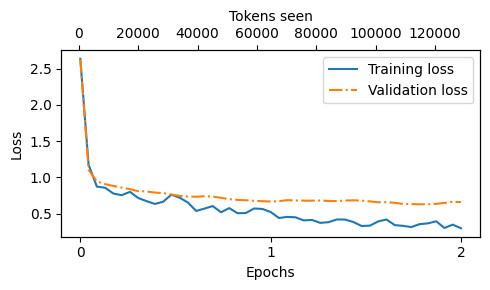

In [35]:
# ============================================================
# 📦 导入绘图函数
# ============================================================

from previous_chapters import plot_losses
# ⚠️ 替代方案：
# 如果本地没有 previous_chapters.py 文件，可从 llms-from-scratch 包导入：
# from llms_from_scratch.ch05 import plot_losses
# 说明：
# - plot_losses() 用于绘制训练集与验证集损失随训练进度变化的曲线


# ============================================================
# 🔢 构造用于绘图的 epoch 张量
# ============================================================

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# 说明：
# - torch.linspace(start, end, steps) 生成从 start 到 end 的均匀间隔张量
# - start=0，end=num_epochs，steps=len(train_losses)
# - 作用：将每次记录的训练损失映射到对应的 epoch 位置，便于绘制曲线


# ============================================================
# 📈 绘制训练和验证损失曲线
# ============================================================

plot_losses(
    epochs_tensor,  # x 轴：训练轮数或评估时对应的 epoch
    tokens_seen,    # 可选参数：已训练 token 数量，作为辅助信息
    train_losses,   # y1 轴：训练集损失
    val_losses      # y2 轴：验证集损失
)
# 功能：
# - 将训练过程中的损失变化可视化
# - 便于观察模型收敛情况、是否过拟合或欠拟合
# - train_losses 与 val_losses 的对比曲线是分析模型性能的关键


- 如我们所见，在第一个 epoch 开始时，损失迅速下降，这意味着模型开始快速学习。
- 我们可以看到，大约在训练 1 个 epoch 时，出现了轻微的过拟合现象。


## 7.7 提取并保存模型生成的响应


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/18.webp?1" width=500px>

- 在本节中，我们将保存测试集的模型响应，以便在下一节进行评分
- 我们还会保存一份模型副本，以便将来使用
- 但首先，让我们简要看看微调后的模型生成的响应


In [36]:
# ============================================================
# 🎯 固定随机数种子，保证结果可复现
# ============================================================

torch.manual_seed(123)
# 说明：
# - 固定 PyTorch 随机种子，确保模型生成文本的随机性一致
# - 对比实验或教学演示时非常重要


# ============================================================
# 🔄 遍历测试集中的前 3 个样本
# ============================================================

for entry in test_data[:3]:
    # entry 是一个字典，通常包含：
    # - entry['instruction']: 指令文本
    # - entry['input']: 输入文本（可选）
    # - entry['output']: 正确输出文本


    # ============================================================
    # 📝 将测试样本格式化为模型输入文本
    # ============================================================

    input_text = format_input(entry)
    # 作用：
    # - 将指令、输入等字段组合成 GPT 模型可读的 prompt
    # - 通常包含分隔符，例如 "### Instruction:" / "### Input:" / "### Response:"


    # ============================================================
    # 🔢 将输入文本转换为 token id，并调用模型生成输出
    # ============================================================

    token_ids = generate(
        model=model,                                     # 已训练 GPT 模型
        idx=text_to_token_ids(input_text, tokenizer).to(device),  # 文本 → token id → 移动到设备
        max_new_tokens=256,                              # 本次生成最大 token 数量
        context_size=BASE_CONFIG["context_length"],      # 上下文窗口长度
        eos_id=50256                                     # 遇到结束符时停止生成
    )
    # 输出：
    # - token_ids：模型生成的 token id 序列


    # ============================================================
    # 🔄 将生成的 token id 转换回可读文本
    # ============================================================

    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 功能：
    # - token id → 可读文本
    # - 包含原始输入 + 模型生成的响应文本


    # ============================================================
    # 📝 提取模型实际生成的回答部分
    # ============================================================

    response_text = (
        generated_text[len(input_text):]  # 去掉原始输入部分
        .replace("### Response:", "")     # 移除模板标签
        .strip()                          # 去掉首尾空格
    )


    # ============================================================
    # 🖨️ 打印输入文本、正确输出和模型生成的输出
    # ============================================================

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")
    # 输出示例：
    # 1️⃣ 原始输入文本（包含指令/上下文）
    # 2️⃣ 正确输出（测试集标注）
    # 3️⃣ 模型生成输出
    # 4️⃣ 分隔线，便于阅读每个样本的对比


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- 从测试集的指令、给定的答案以及模型生成的响应来看，模型表现相对不错
- 第一条和最后一条指令的答案显然是正确的
- 第二条答案接近正确；模型回答为“cumulus cloud”（积云）而不是“cumulonimbus”（积雨云）（不过请注意，积云可以发展成积雨云，而积雨云有能力产生雷暴）
- 最重要的是，可以看出模型评估不像上一章那样简单，在上一章中，我们只需计算垃圾邮件/非垃圾邮件分类正确的百分比即可获得分类准确率
- 在实际操作中，经过指令微调的 LLM（如聊天机器人）的评估方法有多种：
  - 短答案和多选题基准测试，例如 MMLU（"Measuring Massive Multitask Language Understanding"，[https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)），用于测试模型的知识
  - 与其他 LLM 的人工偏好比较，例如 LMSYS 聊天机器人竞技场 ([https://arena.lmsys.org](https://arena.lmsys.org))
  - 自动化对话基准测试，其中使用另一个 LLM（如 GPT-4）评估响应，例如 AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- 在下一节中，我们将使用类似 AlpacaEval 的方法，使用另一个 LLM 来评估我们模型的响应；不过，我们将使用自己的测试集，而不是公开的基准数据集
- 为此，我们将模型响应添加到 `test_data` 字典中，并保存为 `"instruction-data-with-response.json"` 文件进行记录，以便在需要时可以在独立的 Python 会话中加载和分析


In [37]:
# ============================================================
# 📦 导入 tqdm，用于显示进度条
# ============================================================

from tqdm import tqdm
# 说明：
# - tqdm 是 Python 的进度条库
# - 在处理较大数据集时，可以实时显示循环进度，便于监控推理过程


# ============================================================
# 🔄 遍历测试集，并使用 tqdm 显示进度条
# ============================================================

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    # i: 当前样本索引
    # entry: 测试样本字典
    # total=len(test_data): tqdm 显示进度条总长度

    # ============================================================
    # 📝 格式化输入文本
    # ============================================================

    input_text = format_input(entry)
    # 将测试样本格式化为 GPT 模型可读的 prompt


    # ============================================================
    # 🔢 将文本转换为 token id 并生成模型输出
    # ============================================================

    token_ids = generate(
        model=model,                                     # 已训练 GPT 模型
        idx=text_to_token_ids(input_text, tokenizer).to(device),  # 文本 → token id → 移动到设备
        max_new_tokens=256,                              # 最大生成 token 数
        context_size=BASE_CONFIG["context_length"],      # 上下文窗口长度
        eos_id=50256                                     # 遇到结束符停止生成
    )


    # ============================================================
    # 🔄 将 token id 转换回可读文本
    # ============================================================

    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 输出包含原始输入 + 模型生成的文本


    # ============================================================
    # 📝 提取模型生成的响应文本
    # ============================================================

    response_text = (
        generated_text[len(input_text):]  # 去掉输入部分
        .replace("### Response:", "")     # 移除模板标签
        .strip()                          # 去掉首尾空格
    )


    # ============================================================
    # 💾 将模型生成的响应保存回测试数据字典
    # ============================================================

    test_data[i]["model_response"] = response_text
    # 每个样本新增一个字段 "model_response"，存储模型生成结果
    # 便于后续分析、对比或保存到文件


# ============================================================
# 📂 将包含模型响应的测试数据保存为 JSON 文件
# ============================================================

with open("instruction-data-with-response.json", "w") as file:
    json.dump(
        test_data,   # 要保存的数据
        file,        # 文件对象
        indent=4     # 缩进格式化，使 JSON 文件可读性更好
    )
# 说明：
# - 保存后的文件每个样本包含原始输入、正确输出、以及模型生成的响应
# - 可用于后续评估、展示或共享


100%|██████████| 110/110 [01:20<00:00,  1.37it/s]


- 我们再检查一个条目，以确认模型生成的回答是否已正确添加到 `test_data` 字典中


In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 最后，我们还将保存模型，以便将来如果需要可以重新使用


In [39]:
# ============================================================
# 📦 导入正则表达式模块
# ============================================================

import re
# 说明：
# - re 模块用于处理字符串模式匹配和替换
# - 这里用于生成文件名时去掉不合法字符（如空格、括号）


# ============================================================
# 🔧 构造模型保存文件名
# ============================================================

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
# 说明：
# 1️⃣ CHOOSE_MODEL: 模型名称字符串，例如 "gpt2-medium (355M)"
# 2️⃣ re.sub(r'[ ()]', '', CHOOSE_MODEL):
#    - 使用正则表达式删除空格和括号
#    - 结果: "gpt2-medium355M"
# 3️⃣ f"...-sft.pth":
#    - 将处理后的模型名称与后缀 "-sft.pth" 拼接
#    - 最终文件名: "gpt2-medium355M-sft.pth"


# ============================================================
# 💾 保存模型权重
# ============================================================

torch.save(model.state_dict(), file_name)
# 说明：
# - model.state_dict(): 获取模型的所有参数和缓冲区（字典形式）
# - torch.save(..., file_name): 将模型权重保存为文件，可用于后续加载或共享
# - 文件扩展名 ".pth" 是 PyTorch 常用保存格式


# ============================================================
# 🖨️ 输出保存信息
# ============================================================

print(f"Model saved as {file_name}")
# 输出示例：
# Model saved as gpt2-medium355M-sft.pth


# ============================================================
# ⚠️ 加载已保存模型权重示例
# ============================================================

# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))
# 说明：
# - torch.load(...) 读取保存的权重字典
# - model.load_state_dict(...) 将权重加载到模型中
# - 加载后可继续训练或用于推理


Model saved as gpt2-medium355M-sft.pth


## 7.8 评估微调后的 LLM


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/19.webp?1" width=500px>

- 在本节中，我们使用另一个更大的 LLM 来自动评估微调后的 LLM 响应
- 具体而言，我们使用 Meta AI 的指令微调版 80 亿参数 Llama 3 模型，该模型可以通过 ollama ([https://ollama.com](https://ollama.com)) 在本地运行
- （或者，如果你希望使用更强大的 LLM，比如通过 OpenAI API 的 GPT-4，请参阅 [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) 笔记本）


- Ollama 是一个高效运行 LLM 的应用程序
- 它是对 llama.cpp 的封装 ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp))，后者使用纯 C/C++ 实现 LLM，以最大化运行效率
- 请注意，它是用于生成文本（推理）的工具，而不是用于训练或微调 LLM
- 在运行下面代码之前，请访问 [https://ollama.com](https://ollama.com) 并按照说明安装 ollama（例如，点击“Download”按钮并下载适合你操作系统的 ollama 应用程序）


- 对于 macOS 和 Windows 用户，点击你下载的 ollama 应用程序；如果提示是否安装命令行使用功能，请选择“yes”
- Linux 用户可以使用 ollama 网站提供的安装命令

- 一般来说，在命令行中使用 ollama 之前，我们必须要么启动 ollama 应用程序，要么在另一个终端中运行 `ollama serve`

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/20.webp?1" width=700px>


---

**注意**：

- 如上所述，在终端运行 `ollama serve` 时，可能会遇到错误信息 `Error: listen tcp 127.0.0.1:11434: bind: address already in use`
- 如果出现这种情况，可以尝试使用命令 `OLLAMA_HOST=127.0.0.1:11435 ollama serve`（如果该地址也被占用，可以将端口号依次加 1，直到找到未被占用的地址）

---


- 在另一个终端中运行 ollama 应用程序或 `ollama serve` 后，在命令行执行以下命令以尝试 8 十亿参数的 Llama 3 模型（该模型首次执行命令时会自动下载，占用 4.7 GB 存储空间）

```bash
# 8B 模型
ollama run llama3

```


输出示例如下：

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

注意，llama3 指的是经过指令微调的 8 十亿参数 Llama 3 模型

使用 ollama 和 "llama3" 模型（8B 参数）需要 16 GB RAM；如果你的设备不支持，可以尝试更小的模型，例如 3.8B 参数的 phi-3 模型，设置 model = "phi-3"，只需要 8 GB RAM

另外，如果设备支持，你也可以使用更大的 70 十亿参数 Llama 3 模型，只需将 llama3 替换为 llama3:70b

下载完成后，你会看到一个命令行提示符，可以与模型进行交互

尝试输入提示，例如 "What do llamas eat?"，输出示例如下：

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- 你可以使用输入 `/bye` 来结束本次会话


- 以下代码用于在继续使用 ollama 评估上一节生成的测试集响应之前，检查 ollama 会话是否运行正常


In [ ]:
# ============================================================
# 📦 导入 psutil 模块，用于系统进程管理
# ============================================================

import psutil
# 说明：
# - psutil 是 Python 的系统监控库
# - 可获取系统进程、CPU、内存等信息
# - 这里用于检查特定进程是否正在运行


# ============================================================
# 🔍 定义函数：检查指定进程是否运行
# ============================================================

def check_if_running(process_name):
    """
    功能：
    - 检查系统中是否存在指定名称的进程
    参数：
    - process_name (str): 要检查的进程名称，例如 "ollama"
    返回：
    - running (bool): True 表示进程正在运行，False 表示未运行
    """
    running = False  # 初始化状态为未运行
    for proc in psutil.process_iter(["name"]):
        # proc.info["name"] 获取进程名称
        if process_name in proc.info["name"]:
            running = True  # 找到进程，设置为 True
            break           # 找到一个即可，退出循环
    return running


# ============================================================
# 🔎 检查 Ollama 是否正在运行
# ============================================================

ollama_running = check_if_running("ollama")
# 说明：
# - 调用自定义函数，返回 True/False
# - 用于确保后续操作依赖 Ollama 服务时不会出错


# ============================================================
# ⚠️ 如果 Ollama 未运行，则抛出异常
# ============================================================

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
# 说明：
# - RuntimeError 会中断程序
# - 提示用户先启动 Ollama 服务


# ============================================================
# 🖨️ 输出 Ollama 是否运行状态
# ============================================================

print("Ollama running:", check_if_running("ollama"))
# 输出示例：
# Ollama running: True
# 可用于确认 Ollama 已经启动


Ollama running: True


In [ ]:
# ============================================================
# ⚠️ 可选单元格说明
# ============================================================

# 说明：
# - 本单元格可用于重启 Notebook 后仅运行 7.7 节（测试/推理部分）
# - 无需重新运行前面训练模型等耗时操作
# - 适合教学演示或快速测试模型推理结果


# ============================================================
# 📦 导入 JSON 和 tqdm 库
# ============================================================

import json
from tqdm import tqdm
# 说明：
# - json: 用于加载和保存 JSON 文件
# - tqdm: 用于显示循环进度条，方便观察处理进度


# ============================================================
# 📂 指定包含模型生成响应的测试数据文件路径
# ============================================================

file_path = "instruction-data-with-response.json"
# 说明：
# - 文件中包含测试样本及模型生成的 "model_response" 字段
# - 之前推理保存的 JSON 文件


# ============================================================
# 🔄 从 JSON 文件加载测试数据
# ============================================================

with open(file_path, "r") as file:
    test_data = json.load(file)
# 说明：
# - json.load(file) 将 JSON 文件解析为 Python 列表或字典
# - test_data: 列表，每个元素是一个字典，包含：
#   - 'instruction': 指令文本
#   - 'input': 输入文本
#   - 'output': 正确输出
#   - 'model_response': 模型生成的响应（如果已生成）


# ============================================================
# 📝 定义函数：格式化输入文本以供模型推理
# ============================================================

def format_input(entry):
    """
    功能：
    - 将单个测试样本 entry 格式化为 GPT 模型可读的 prompt
    参数：
    - entry: 测试样本字典，包含 'instruction' 和可选 'input'
    返回：
    - input_text: 拼接后的字符串，用于模型生成
    """

    # ============================================================
    # 🔹 构造 instruction 部分
    # ============================================================

    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    # 说明：
    # - 模板说明任务背景
    # - 将样本的 'instruction' 字段插入模板中
    # - 便于模型理解任务意图


    # ============================================================
    # 🔹 构造 input 部分（可选）
    # ============================================================

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    # 说明：
    # - 如果样本包含额外输入，则添加 "### Input:" 标签及输入内容
    # - 否则 input_text 为空字符串
    # - 保证格式统一，便于模型处理


    # ============================================================
    # 🔹 拼接 instruction 和 input，返回完整 prompt
    # ============================================================

    return instruction_text + input_text
    # 返回示例：
    # "Below is an instruction that describes a task. Write a response ... 
    #  ### Instruction: <instruction_text>
    #  ### Input: <input_text>"


- 现在，与之前使用的 `ollama run` 命令交互模型的另一种方法是通过 Python 使用其 REST API，如下函数所示
- 在运行本笔记本的下一单元格之前，请确保 ollama 仍在运行（前面的代码单元格应该打印 `"Ollama running: True"`）
- 接下来，运行下面的代码单元格以查询模型


In [ ]:
# ============================================================
# 📦 导入 requests 库
# ============================================================

import requests  # noqa: F811
# 说明：
# - requests 是 Python 中常用的 HTTP 客户端库
# - 用于发送 POST/GET 请求，获取 Web API 返回的数据
# - noqa: F811 是告诉 linter 忽略重复导入警告

# ⚠️ 另一种方法：
# import urllib.request
# - 可使用 urllib 发送请求，但在某些 VPN 或网络环境下可能不稳定


# ============================================================
# 🔹 定义函数：向 Ollama 模型发送查询并获取响应
# ============================================================

def query_model(
    prompt,                 # 用户输入的文本或问题
    model="llama3",         # 指定模型名称，默认 "llama3"
    url="http://localhost:11434/api/chat"  # Ollama API 地址
):
    """
    功能：
    - 向本地 Ollama 服务发送 POST 请求
    - 获取模型返回的文本内容
    参数：
    - prompt: 用户输入的问题或指令
    - model: 指定使用的模型
    - url: Ollama 本地 API 地址
    返回：
    - response_data: 模型生成的回答文本
    """

    # ============================================================
    # 🔹 构造请求数据 payload（字典格式）
    # ============================================================

    data = {
        "model": model,              # 要调用的模型
        "messages": [                # 对话消息列表
            {"role": "user", "content": prompt}  # 用户输入
        ],
        "options": {                 # 模型生成设置
            "seed": 123,             # 固定随机种子，保证可复现
            "temperature": 0,        # 温度为 0，保证确定性输出
            "num_ctx": 2048          # 上下文长度，最大 token 数
        }
    }


    # ============================================================
    # 🔹 发送 POST 请求获取模型响应（requests 版本）
    # ============================================================

    with requests.post(url, json=data, stream=True, timeout=30) as r:
        # 说明：
        # - url: Ollama API 地址
        # - json=data: 自动将字典序列化为 JSON 并设置 Content-Type
        # - stream=True: 分块读取返回内容
        # - timeout=30: 请求超时时间 30 秒
        r.raise_for_status()  # 如果响应状态码不是 2xx，则抛出异常

        response_data = ""  # 初始化空字符串，用于累加返回内容

        # 遍历服务器返回的每一行
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue  # 忽略空行
            response_json = json.loads(line)  # 将 JSON 字符串解析为字典
            if "message" in response_json:
                # 提取模型生成的文本内容并累加
                response_data += response_json["message"]["content"]

    return response_data  # 返回模型生成的完整回答文本


# ============================================================
# 🔹 调用函数示例
# ============================================================

model = "llama3"  # 指定要调用的模型名称

result = query_model("What do Llamas eat?", model)
# 说明：
# - 向 Ollama 模型发送问题 "What do Llamas eat?"
# - 返回模型生成的回答

print(result)  # 打印模型回答


Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- 现在，使用上面定义的 `query_model` 函数，我们可以评估微调模型的响应；让我们在上一节中查看的前三个测试集响应上试一试


In [ ]:
# ============================================================
# 🔄 遍历测试数据前 3 条样本
# ============================================================

for entry in test_data[:3]:
    # entry: 测试样本字典，包含字段：
    # - 'instruction': 指令文本
    # - 'input': 输入文本
    # - 'output': 正确输出
    # - 'model_response': 模型生成的响应


    # ============================================================
    # 🔹 构造评分 prompt
    # ============================================================

    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    # 说明：
    # - 使用 format_input(entry) 构造 GPT 模型可读的输入
    # - 将正确输出和模型输出嵌入 prompt
    # - 明确要求模型对生成文本进行打分，范围 0-100
    # - 使用 f-string 拼接文本，便于传递给 query_model()


    # ============================================================
    # 🖨️ 输出测试数据的正确响应
    # ============================================================

    print("\nDataset response:")
    print(">>", entry['output'])
    # 输出示例：
    # >> <样本的正确答案>


    # ============================================================
    # 🖨️ 输出模型生成的响应
    # ============================================================

    print("\nModel response:")
    print(">>", entry["model_response"])
    # 输出示例：
    # >> <模型生成的文本>


    # ============================================================
    # 🖨️ 调用 query_model 对模型响应进行评分
    # ============================================================

    print("\nScore:")
    print(">>", query_model(prompt))
    # 说明：
    # - query_model(prompt) 会将评分请求发送到 Ollama 模型
    # - 返回模型给出的评分（0-100）


    # ============================================================
    # 🖨️ 输出分割线，便于区分样本
    # ============================================================

    print("\n-------------------------")



Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

---


**注意：更好的评估提示**

- [一位读者（Ayoosh Kathuria）建议](https://github.com/rasbt/LLMs-from-scratch/discussions/449) 使用更长、更完善的提示，对响应进行 1–5 分的评分（而不是 1 到 100），并采用评分标准，从而得到更准确、噪声更少的评估：


```
prompt = """
You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance.
You will be given an instruction, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing the evaluation criteria.
Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
Please do not generate any other opening, closing, and explanations.

Here is the rubric you should use to build your answer:
1: The response fails to address the instructions, providing irrelevant, incorrect, or excessively verbose information that detracts from the user's request.
2: The response partially addresses the instructions but includes significant inaccuracies, irrelevant details, or excessive elaboration that detracts from the main task.
3: The response follows the instructions with some minor inaccuracies or omissions. It is generally relevant and clear, but may include some unnecessary details or could be more concise.
4: The response adheres to the instructions, offering clear, accurate, and relevant information in a concise manner, with only occasional, minor instances of excessive detail or slight lack of clarity.
5: The response fully adheres to the instructions, providing a clear, accurate, and relevant answer in a concise and efficient manner. It addresses all aspects of the request without unnecessary details or elaboration

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the instruction, the reference answer, and the response.

Instruction: {instruction}
Reference Answer: {reference}
Answer: {answer}


Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """
```


- 更多背景和信息请参见 [此处](https://github.com/rasbt/LLMs-from-scratch/discussions/449)



---

- 正如我们所看到的，Llama 3 模型提供了合理的评估，如果模型回答不完全正确，它也会给予部分分数，例如“cumulus cloud”的答案。
- 请注意，上述提示会返回非常详细的评估结果；我们可以调整提示，使其生成 0 到 100 之间的整数响应（100 为最佳），以便计算模型的平均分。
- 对测试集中 110 条条目的评估在 M3 MacBook Air 笔记本上大约需要 1 分钟。


In [ ]:
# ============================================================
# 🔹 定义函数：生成模型评分
# ============================================================

def generate_model_scores(json_data, json_key, model="llama3"):
    """
    功能：
    - 对 JSON 数据中的每条样本调用模型评分
    参数：
    - json_data: 列表，每个元素为字典，包含模型响应等字段
    - json_key: 要评分的字段名称，例如 "model_response"
    - model: 调用的 Ollama 模型名称，默认 "llama3"
    返回：
    - scores: 列表，每个元素为整数评分（0-100）
    """

    scores = []  # 初始化空列表，用于存储评分结果

    # ============================================================
    # 🔄 遍历 JSON 数据中的每条样本，并显示进度条
    # ============================================================

    for entry in tqdm(json_data, desc="Scoring entries"):
        # entry: 当前样本字典
        # tqdm(..., desc="Scoring entries") 显示进度条和描述

        # ============================================================
        # 🔹 构造评分 prompt
        # ============================================================

        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        # 说明：
        # - format_input(entry): 将 instruction + input 拼接为 GPT 可读文本
        # - entry['output']: 正确答案
        # - entry[json_key]: 模型生成的文本
        # - 明确要求模型只返回整数评分（0-100）


        # ============================================================
        # 🔹 调用 query_model 获取评分
        # ============================================================

        score = query_model(prompt, model)
        # 返回值为模型生成的评分字符串


        # ============================================================
        # 🔹 将评分转换为整数，并处理可能的异常
        # ============================================================

        try:
            scores.append(int(score))  # 转换为整数并添加到列表
        except ValueError:
            # 如果模型返回的不是整数（例如包含文本），则输出提示并跳过
            print(f"Could not convert score: {score}")
            continue


    # ============================================================
    # 🔹 返回评分列表
    # ============================================================

    return scores


# ============================================================
# 🔹 调用函数，对 test_data 的 "model_response" 生成评分
# ============================================================

scores = generate_model_scores(test_data, "model_response")
# 返回列表，每个元素为 0-100 的整数评分

# ============================================================
# 🖨️ 输出评分统计信息
# ============================================================

print(f"Number of scores: {len(scores)} of {len(test_data)}")
# 输出已成功评分的样本数量和总样本数量

print(f"Average score: {sum(scores)/len(scores):.2f}\n")
# 计算并输出平均评分，保留两位小数


Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32



- 我们的模型平均得分超过 50，这可以作为参考点，用于将模型与其他模型进行比较，或尝试其他可能提升模型表现的训练设置。
- 请注意，截至目前，ollama 在不同操作系统上的运行并非完全确定性，因此你得到的数值可能会与上面显示的略有差异。


- 作为参考，原始模型的表现如下：
  - Llama 3 8B 基础模型（base model）的平均得分为 58.51
  - Llama 3 8B 指令微调模型（instruct model）的平均得分为 82.65


## 7.9 总结

### 7.9.1 接下来做什么

- 这标志着本书的最后一章
- 我们涵盖了 LLM 开发周期的主要步骤：实现 LLM 架构、对 LLM 进行预训练以及微调

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/21.webp?1" width=500px>

- 在本章描述的指令微调之后，有时会进行一个可选步骤：偏好微调（preference finetuning）
- 偏好微调过程对于定制模型以更好地符合特定用户偏好特别有用；如果你感兴趣，可以查看 [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) 文件夹

- 该 GitHub 仓库还包含大量额外的奖励材料，如果你感兴趣，可以在仓库的 README 页面中的 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分获取更多信息

### 7.9.2 在快速发展的领域中保持更新

- 本节没有代码

### 7.9.3 最后的话

- 希望你喜欢这段从零实现 LLM 并编写预训练与微调函数的旅程
- 在我看来，从零实现 LLM 是理解 LLM 工作原理的最佳方式；希望通过这种方法你能获得更深的理解
- 虽然本书以教育为目的，但你可能会对使用不同且更强大的 LLM 在实际应用中感兴趣
  - 为此，你可以考虑使用流行工具，如 axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) 或 LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt))，我也参与了这些项目的开发


## 总结与收获

- 参考 [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) 脚本，这是一个独立的指令微调完整脚本
- [./ollama_evaluate.py](./ollama_evaluate.py) 是基于第 7.8 节的独立脚本，用于通过 Ollama 和 Llama 3 对包含 `"output"` 和 `"response"` 键的 JSON 文件进行评估
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) 展示了如何在新会话中加载微调后的模型
- 练习题答案请见 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)


## 接下来做什么？

- 恭喜你完成了本书；如果你想寻找更多资源，我在这个 GitHub 仓库中添加了几个额外的附加章节，可能会引起你的兴趣
- 完整的附加材料列表可以在主 README 的 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分查看
- 以下是我特别推荐的几个：
  1. [从零实现的大语言模型对齐的直接偏好优化（DPO）](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb)，实现了一种流行的偏好微调机制，用于让本章模型更好地符合人类偏好
  2. [从零实现的 Llama 3.2（独立 Notebook）](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb)，从零实现 Meta AI 流行的 Llama 3.2，包括加载官方预训练权重；如果你想做一些额外实验，可以在各章节中将 `GPTModel` 替换为 `Llama3Model` 类（应可作为 1:1 替换）
  3. [将 GPT 转换为 Llama](../../ch05/07_gpt_to_llama)，提供代码和逐步指南，解释 GPT-2 与各 Llama 模型的区别
  4. [理解 Embedding 层与 Linear 层的区别](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb)，概念性讲解 PyTorch 中在 LLM 输入阶段使用的 `Embedding` 层在数学上等价于应用于 one-hot 编码数据的线性层
- 祝你阅读愉快！
